In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Read in that data

In [24]:
df = pd.read_csv('data/cl_data.csv')

In [25]:
with open('resources/hoods.txt', 'r') as inf:
    hoodnames = inf.read().splitlines()
    #hoodnames = inf.read()
    #hoodnames = re.split(r',\s*', hoodnames)

In [8]:
hoodnames

['seattle',
 'bellevue',
 'capitol hill',
 'everett',
 'kent',
 'redmond',
 'kirkland',
 'renton',
 'lynnwood',
 'tacoma',
 'puyallup',
 'bothell',
 'university place',
 'downtown',
 'lakewood',
 'ballard',
 'federal way',
 'first hill',
 'west seattle',
 'south lake union',
 'belltown',
 'queen anne',
 'auburn',
 'silverdale',
 'issaquah',
 'north tacoma',
 'downtown seattle',
 'bremerto',
 'bremerton',
 'mill creek',
 'olympia',
 'des moines',
 'lacey',
 'lower queen anne',
 'woodinville',
 'burien',
 'microsoft',
 'amazon',
 'eastlake',
 'juanita',
 'magnolia',
 'wallingford',
 'mercer island',
 'shoreline',
 'gig harbor',
 'fremont',
 'mukilteo',
 'north seattle',
 'newcastle',
 'kenmore',
 'marysville',
 'fife',
 'sammamish',
 'alki',
 'totem lake',
 'northgate',
 'south everett',
 'tumwater',
 'tukwila',
 'arlington',
 'university district',
 'ravenna',
 'silver lake',
 'poulsbo',
 'port orchard',
 'seatac',
 'edmonds',
 'crown hill',
 'columbia city',
 'snoqualmie',
 'fairwood',

# Curated list of Seattle-area neighborhoods -- some manually added in.

In [47]:
neighbs = """"'Adams' 'Alki' 'Arbor Heights' 'Atlantic' 'Ballard' 'Belltown' 'Bellevue' Bitter Lake'
 'Bothell' 'Bremerton' 'Briarcliff' 'Brighton' 'Broadview' 'Broadway' 'Bryant' 'Capitol Hill' 'Cedar Park'
 'Central Business District' 'Columbia City' 'Crown Hill' 'Dunlap'
 'East Queen Anne' 'Eastlake' 'Everett' 'Fairmount Park' 'Fauntleroy' 'Federal Way' 'First Hill'
 'Fremont' 'Gatewood' 'Genesee' 'Georgetown' 'Green Lake' 'Greenlake' 'Greenwood'
 'Haller Lake' 'Harrison/Denny-Blaine' 'High Point' 'Highland Park'
 'Holly Park' 'Industrial District' 'Interbay' 'International District' 'Issaquah' 'Kirkland'
 'Laurelhurst' 'Lawton Park' 'Leschi' 'Lower Queen Anne' 'Loyal Heights'
 'Madison Park' 'Madrona' 'Mann' 'Maple Leaf' 'Matthews Beach'
 'Meadowbrook' 'Mid-Beacon Hill' 'Mill Creek' Minor' 'Montlake' 'Mount Baker' 'Newcastle'
 'North Admiral' 'North Beach/Blue Ridge' 'North Beacon Hill'
 'North College Park' 'North Delridge' 'North Queen Anne' 'Olympic Hills'
 'Phinney Ridge' 'Pike-Market' 'Pinehurst' 'Pioneer Square' 'Portage Bay'
 'Rainier Beach' 'Ravenna' 'Redmond' 'Renton' 'Riverview' 'Roosevelt' 'Roxhill' 'Seaview'
 'Seward Park' 'Shoreline' 'South Beacon Hill' 'South Delridge' 'South Lake Union'
 'South Park' 'Southeast Magnolia' 'Stevens' 'Sunset Hill'
 'University District' 'U District' 'UDistrict' 'Victory Heights' 'View Ridge' 'Wallingford'
 'Wedgwood' 'West Seattle' 'West Queen Anne' 'West Woodland' 'Westlake'
 'Whittier Heights' 'Windermere' 'Yesler Terrace'""".split("'")

In [48]:
hoods = [name.lower() for name in neighbs if re.match(r'\w+', name)]

In [5]:
hoods

['adams',
 'alki',
 'arbor heights',
 'atlantic',
 'ballard',
 'belltown',
 'bellevue',
 'bothell',
 'briarcliff',
 'brighton',
 'broadview',
 'broadway',
 'bryant',
 'capitol hill',
 'cedar park',
 'central business district',
 'columbia city',
 'crown hill',
 'dunlap',
 'east queen anne',
 'eastlake',
 'fairmount park',
 'fauntleroy',
 'federal way',
 'first hill',
 'fremont',
 'gatewood',
 'genesee',
 'georgetown',
 'green lake',
 'greenlake',
 'greenwood',
 'haller lake',
 'harrison/denny-blaine',
 'high point',
 'highland park',
 'holly park',
 'industrial district',
 'interbay',
 'international district',
 'issaquah',
 'kirkland',
 'laurelhurst',
 'lawton park',
 'leschi',
 'lower queen anne',
 'loyal heights',
 'madison park',
 'madrona',
 'mann',
 'maple leaf',
 'matthews beach',
 'meadowbrook',
 'mid-beacon hill',
 'mill creek',
 'montlake',
 'mount baker',
 'north admiral',
 'north beach/blue ridge',
 'north beacon hill',
 'north college park',
 'north delridge',
 'north quee

# Preprocess the data:
- Strip URLs (or.. should map them to '#url' ???)
- Map neighborhood names to '#hood'
- Tokenize words & punctuation


In [26]:
url_pattern = r'(https?:\/\/)?(www).*[\r\n]*'

In [27]:
punctuation_pattern = r"[#\w'-]+|[.,!?;]+"

In [28]:
def preprocess(text):
    text = text.lower()
    no_urls = re.sub(url_pattern, '', text)
    for hood in hoodnames:
        # hood_pattern = r'\s+{0}\s+'.format(hood)
        #hood_pattern = r' ?'+hood+' ?'
        # Match neighborhood mentions surrounded by whitespace and replace with #hood
        no_urls = re.sub(r' hood ', ' #hood ', no_urls)
    tokenized = re.findall(punctuation_pattern, no_urls)
    return ' '.join([word.lower() for word in tokenized])

In [ ]:

texts = [[word for word in text.lower().split() if word not in hoodnames] for text in df.clean_text]

In [29]:
example = df.loc[0]['body_text']

In [30]:
example

'\r\nSpecial Offer\r\nSave up to $ off move-in costs\r\nThis perfect one bedroom home with a den could be your perfect match!  Located on the first floor, this home offers a stellar view of greenery, and an electric fireplace!   Walk in closet in the bedroom, a size-able den, hallway coat closet, and an outdoor storage closet on your private patio!\r\nLocated in the heart of Mill Creek within walking distance to everything you could possibly need! Easy access to freeways, shopping, and dining!\r\nOffice Hours\r\nMonday: : AM   - : PM\r\nTuesday: : AM   - : PM\r\nWednesday: : AM   - : PM\r\nThursday: : AM   - : PM\r\nFriday: : AM   - : PM\r\nSaturday: : AM   - : PM\r\nSunday: Closed\r\nMonterra in Mill Creek Apartments\r\nMore Photos\r\nhttp://www.equityapartments.com/seattle/mill-creek/monterra-in-mill-creek-apartments?ilsid=\r\nOur community does not accept reusable tenant screening reports.'

In [31]:
preprocess(example)

'special offer save up to off move-in costs this perfect one bedroom home with a den could be your perfect match ! located on the first floor , this home offers a stellar view of greenery , and an electric fireplace ! walk in closet in the bedroom , a size-able den , hallway coat closet , and an outdoor storage closet on your private patio ! located in the heart of mill creek within walking distance to everything you could possibly need ! easy access to freeways , shopping , and dining ! office hours monday am - pm tuesday am - pm wednesday am - pm thursday am - pm friday am - pm saturday am - pm sunday closed monterra in mill creek apartments more photos our community does not accept reusable tenant screening reports .'

In [38]:
df['body_text'] = df['body_text'].apply(preprocess)

In [41]:
df['body_text'].to_string()

"0        special offer save up to off move-in costs thi...\n1        tressa apartments linden ave n , seattle , wa ...\n2        call us today show contact info the perfect on...\n3        #hood ridge apartments #hood everett highway #...\n4        newport crossing apartments in newcastle , wa ...\n5        make it easy - text or call today for more inf...\n6        hearthstone at merrill creek , managed by udr ...\n7        you are home ! live #hood call now show contac...\n8        as you step into this bright br ba unit , suff...\n9        call us today show contact info special offer ...\n10       we invite you to visit woodland commons ! wow ...\n11       brand new apartments in downtown #hood ! come ...\n12       the perfect home at the perfect location . two...\n13       koi inspired lifestyle call now show contact i...\n14       the post western avenue , seattle , wa , want ...\n15       call now - show contact info this is a bedroom...\n16       bright and big remodeled unit 

# Split the data into train & test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['body_text'], df['high_white'], random_state=0)

In [14]:
word_vectorizer = CountVectorizer()

In [15]:
word_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [16]:
word_vectorizer.get_feature_names()

['__',
 '_______',
 '___________________________',
 '_____________________________',
 '___________________________________',
 '_______________________________________',
 '________________________________________',
 '____________________________________________',
 '_______________________________________________',
 '________________________________________________',
 '__________________________________________________',
 '_____________________________________________________',
 '____________________________________________________________',
 '______________________________________________________________________',
 '___________________________________________________________________________',
 '_____________________________________________________________________________',
 '_______________________________________________________________________________',
 '_____________________________________________________________________________________',
 '_________________________________________

In [17]:
X_train_vectorized = word_vectorizer.transform(X_train)

In [18]:
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)

In [19]:
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]

In [20]:
predictions

array([0.27536   , 0.90522695, 0.98130661, ..., 0.75958636, 0.98820131,
       0.84028271])

In [21]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [22]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.957211781830636
F1 score:  0.9003107198342828
accuracy:  0.8992542195472982


In [23]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

(0.0, 1.0)

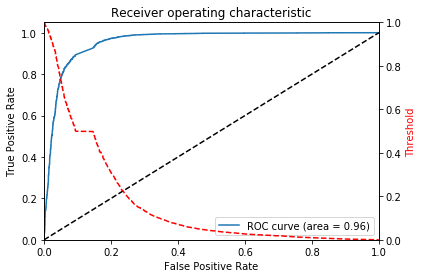

In [24]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [25]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['renton' 'redmond' 'bellevue' 'kent' 'hubbard' 'federal' 'moda' 'henry'
 'seeley' 'lakewood' 'airport' 'mall' 'heronfield' 'rianna' 'westwood'
 'edge' 'fountain' 'cityline' 'beacon' 'international']

Largest Coefs: 
['sage' 'merrill' 'covington' 'llc' 'junction' 'capitol' 'shoreline'
 'retreat' 'woodinville' 'fairways' 'ballard' 'issaquah' 'marq' 'samm'
 'kirkland' 'olivian' 'northshore' 'bradford' 'puyallup' 'olympia']


In [26]:
# lol. still too many neighborhood names... why aren't they getting stripped out???
# another (unrelated) idea: map words to word2vec on general domain pretrained vectors? lol

# Using ngram features

In [27]:
ngram_vectorizer = CountVectorizer(ngram_range=(1,4)).fit(X_train)

In [28]:
ngram_vectorizer.get_feature_names()

['__',
 '__ __',
 '__ __ __',
 '__ __ __ affordable',
 '__ __ affordable',
 '__ __ affordable housing',
 '__ affordable',
 '__ affordable housing',
 '__ affordable housing maximum',
 '_______',
 '_______ _______',
 '_______ _______ _______',
 '_______ _______ _______ people',
 '_______ _______ _______ unit',
 '_______ _______ people',
 '_______ _______ people _______',
 '_______ _______ unit',
 '_______ _______ unit price',
 '_______ people',
 '_______ people _______',
 '_______ people _______ _______',
 '_______ unit',
 '_______ unit price',
 '_______ unit price __',
 '___________________________',
 '___________________________ application',
 '___________________________ application fee',
 '___________________________ application fee non',
 '___________________________ cleaning',
 '___________________________ cleaning fee',
 '___________________________ cleaning fee non',
 '___________________________ tenant',
 '___________________________ tenant responsible',
 '______________________

In [29]:
X_train_ngrams = ngram_vectorizer.transform(X_train)
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_ngrams, y_train)
predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]

In [30]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [31]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.9677409367240346
F1 score:  0.9176169122357463
accuracy:  0.9158707313881983


In [32]:
feature_names = np.array(ngram_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['bellevue' 'kent' 'redmond' 'renton' 'mall' 'lynnwood' 'bellevue wa'
 'renton wa' 'lakewood' 'airport' 'door' 'street seattle wa show' 'city'
 'sheridan' 'redmond wa' 'lakewood wa' 'road bremerton wa available'
 'microsoft' 'sheridan road' 'sheridan road bremerton wa']

Largest Coefs: 
['bremerton' 'union' 'woodinville' 'issaquah' 'beach' 'puyallup wa'
 'edmonds' 'llc' 'mercer' 'capitol' 'ballard' 'junction' 'kirkland wa'
 'west' 'wa available' 'kirkland' 'island' 'nw' 'olympia' 'puyallup']


In [43]:
# AP note (04/14) The neighborhood names are still not complete enough -_-
# also they are still sneaking in somehow... need more work on preproc
# 'kirkland' and 'issaquah' are IN the damn hoods list.. why are they still showing up?!